In [1]:
__author__ = "CHEN CHEN"
__studentID__ = "18M15221"
__date__ = "2018/07/17"

"""
Problem 2 source code

Including the implementation of proximal gradient method and
accelerated proximal gradient method for L1 norm to solve the following question.

w = argmin((w − μ)A(w − μ) + λ∥w∥)
"""
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class PG4L1:
    """
    Proximal gradient method for L1 norm to solve the following question

    w = argmin((w − μ)A(w − μ) + λ∥w∥)

    :param A: array_like, shape(n, n)

    :param mu: array_like, shape(n)

    :param lam: float, default: 2
                Lambda as the  parameter of the regularization. larger values specify stronger regularization.

    :param lr: float, default: None
               Learning rate of the gradient descent.In this problem, the inverse of the maximum eigen value of
               2A will be used.

    :param iter: int, default: 50
                 Iterations of the training.
    """
    def __init__(self, A=None, mu=None, lam=2, lr=None, iter=50):
        self.A = A
        self.mu = mu
        self.w = np.zeros(len(mu))
        self.lam = lam
        self.iter = iter
        self.lr = lr if lr else 1 / max(np.linalg.eig(2*A)[0])
        self.diff2w_hat = []
        if self.lam == 2:
            self.w_hat = np.array([0.82, 1.09])
        if self.lam == 4:
            self.w_hat = np.array([0.64, 0.18])
        if self.lam == 6:
            self.w_hat = np.array([0.33, 0.0])

    @staticmethod
    def _soft_thresholding(u, q):
        """
        Implementation of the soft_thresholding function.

        :param u: float
        :param q: float
        :return: float
        """
        if u > q:
            return u - q
        elif u < -q:
            return u + q
        else:
            return 0

    def _gradient(self, w):
        """
        Gradient of the current weight w.

        :param w: array_like, shape(n)
                  Weight array.

        :return: array_like
        """
        return 2 * self.A.dot(w - self.mu)

    def __call__(self):
        """
        Main routine of the model by using proximal gradient.

        :return: array_like,
                 Trained weight array.
        """
        for _ in range(self.iter):
            gradient = self._gradient(self.w)
            for i in range(len(self.w)):
                self.w[i] = self._soft_thresholding(self.w[i] - self.lr * gradient[i], self.lr * self.lam)
            self.diff2w_hat.append(np.linalg.norm(self.w - self.w_hat))
        return self.w

    def visualize(self):
        """
        Visualize the |w_hat - w| w.r.t the iteration.

        :return: None
        """
        assert self.diff2w_hat, "Call the instance to train the model firstly"
        plt.figure(figsize=(8, 8))
        plt.semilogy(np.arange(self.iter), self.diff2w_hat, c="b")
        plt.xlabel("iteration")
        plt.ylabel("|w_hat - w|")
        plt.title(f"{self.__class__.__name__}_lambda={self.lam}")
        plt.savefig(f"{self.__class__.__name__}_lambda={self.lam}.pdf")
        plt.show()

In [3]:
class APG4L1(PG4L1):
    """
    Accelerated proximal gradient method for L1 norm to solve the following question

    w = argmin((w − μ)A(w − μ) + λ∥w∥)

    :param A: array_like, shape(n, n)

    :param mu: array_like, shape(n)

    :param lam: float, default: 2
                Lambda as the  parameter of the regularization. larger values specify stronger regularization.

    :param lr: float, default: None
               Learning rate of the gradient descent.In this problem, the inverse of the maximum eigen value of
               2A will be used.

    :param iter: int, default: 50
                 Iterations of the training.
    """
    def __init__(self, A=None, mu=None, lam=2, lr=None, iter=50):
        super().__init__(A, mu, lam, lr, iter)
        self.v = None
        self.w_past = None

    @staticmethod
    def _momentum(t, w, w_past):
        """
        Momentum of the current weight w and past weight
        In this case, q(t) = (t - 1) / (t + 2).

        :param t: int,
                  The t-th step to calculate momentum.

        :param w: array_like,
                  Current weight array to calculate momentum.

        :param w_past: array_like,
                       Past weight array to calculate momentum.

        :return: array_like,
                 Momentum.
        """
        return w + (t - 1) / (t + 2) * (w - w_past)

    def __call__(self):
        """
        Main routine of the model by using accelerated proximal gradient.

        :return: array_like,
                 Trained weight array.
        """
        for iter in range(self.iter):
            if iter == 0:
                gradient = self._gradient(self.w)
                self.w_past = np.copy(self.w)
                for i in range(len(self.w)):
                    self.w[i] = self._soft_thresholding(self.w[i] - self.lr * gradient[i], self.lr * self.lam)
                self.diff2w_hat.append(np.linalg.norm(self.w - self.w_hat))
            else:
                self.v = self._momentum(iter, self.w, self.w_past)
                self.w_past = np.copy(self.w)
                gradient = self._gradient(self.v)
                for i in range(len(self.w)):
                    self.w[i] = self._soft_thresholding(self.v[i] - self.lr * gradient[i], self.lr * self.lam)
                self.diff2w_hat.append(np.linalg.norm(self.w - self.w_hat))
        return self.w


In [4]:
A = np.array([[3, 0.5], [0.5, 1]])
mu = np.array([1, 2])

In [5]:
def compare_PG_and_APG(lam):
    # PG
    pg = PG4L1(A, mu, lam=lam)
    pg()
    pg.visualize()

    #APG
    apg = APG4L1(A, mu, lam=lam)
    apg()
    apg.visualize()

    plt.figure(figsize=(8, 8))
    plt.semilogy(np.arange(pg.iter), pg.diff2w_hat, c="b", label="PG")
    plt.semilogy(np.arange(apg.iter), apg.diff2w_hat, c="r", label="APG")
    plt.xlabel("iteration")
    plt.ylabel("|w_hat - w|")
    plt.title(f"comparison_lambda = {pg.lam}")
    plt.legend()
#     plt.savefig(f"comparison_lambda={lam}.pdf")
    plt.show()

# compare PG and APG giving the same lambda 

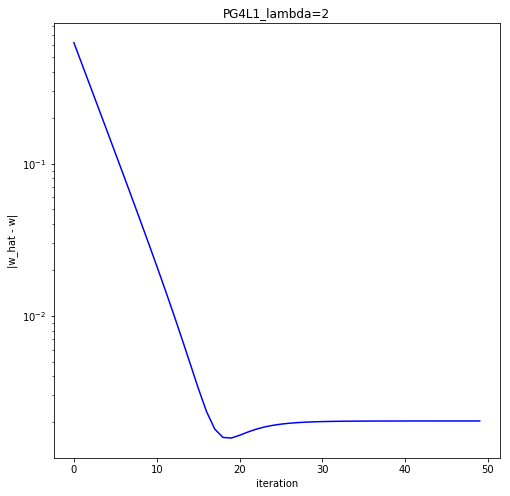

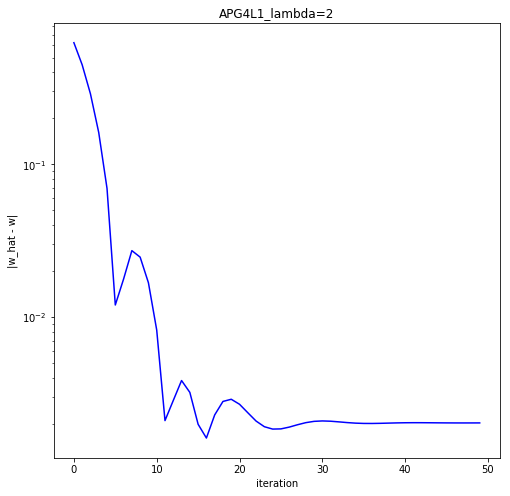

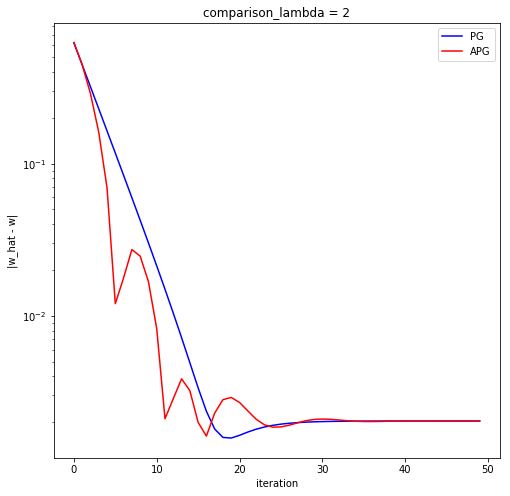

In [6]:
# lambda = 2
compare_PG_and_APG(lam=2)

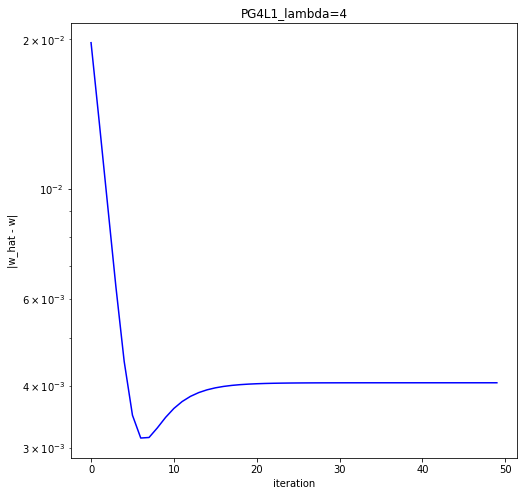

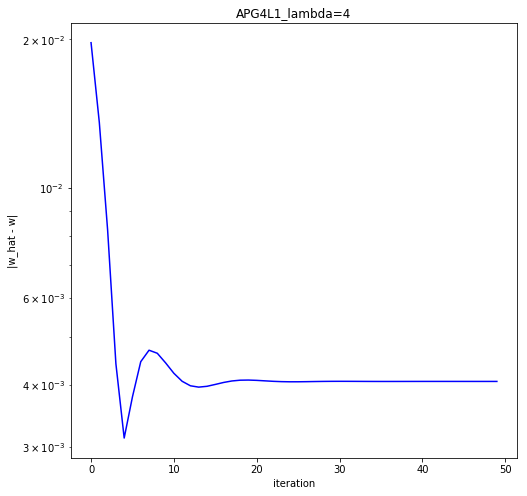

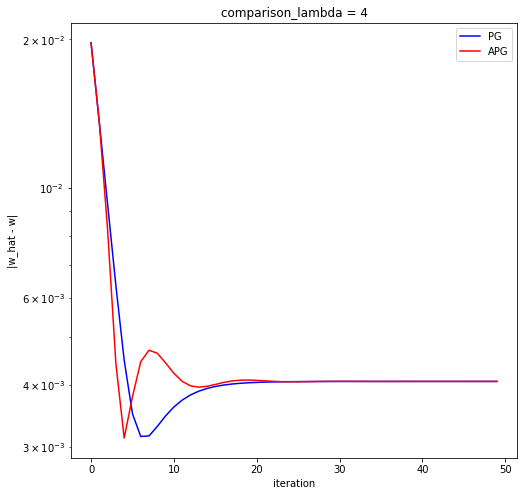

In [7]:
# lambda = 4
compare_PG_and_APG(lam=4)

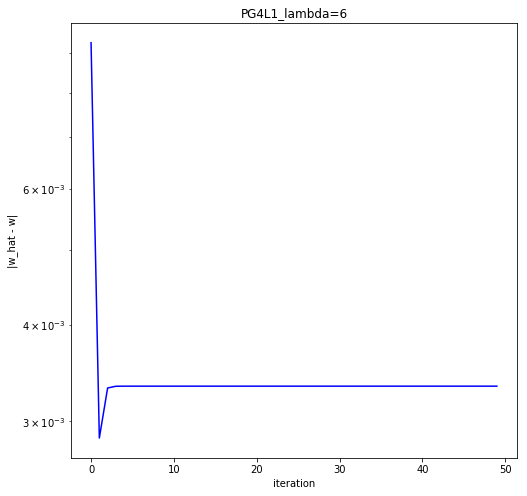

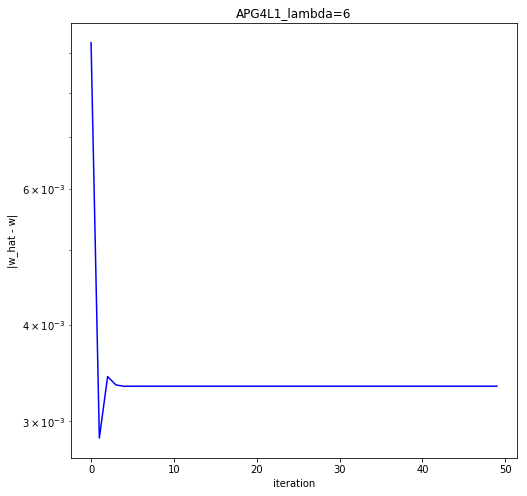

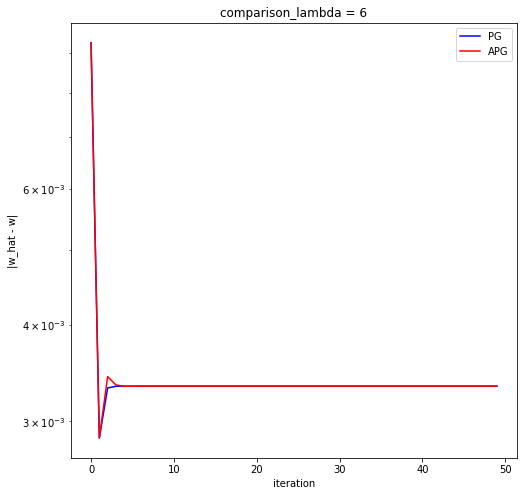

In [8]:
# lambda = 6
compare_PG_and_APG(lam=6)